# Portfolio optimization using a QuantumGAN

### Defining some utility functions for generating random noise and obtaining a Multivariate Normal distribution from the seed dataset

In [10]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def multiDistribution(data_seed): # data_seed is the initial seed dataset
    mean = torch.mean(data_seed, axis=0)
    covariance = torch.cov(torch.permute(data_seed, (1, 0)))
    distribution = MultivariateNormal(loc=mean, covariance_matrix=covariance)
    return distribution

def generate_random_noise(batch_size, sample_dim): #  we use batch size 256 and sample_dim 5
    return torch.randn(batch_size, sample_dim).to(device)

### Loading the portfolio prices dataset to obtain the mean and covariance

In [ ]:
import torch
import pandas as pd
import numpy as np

import torch
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

prices = pd.read_csv("../data/prices.csv", index_col=0)

prices = prices.iloc[:, :5] # use only the first 5 assets

assets = list(prices.columns) # the assets in the portfolio
num_assets = len(assets)

mean = torch.Tensor(np.array(prices.pct_change().mean() * 252)).to(device)
covariance = torch.Tensor(np.array(prices.pct_change().cov() * 252)).to(device)
# pct_change() computes the percentage change between the current and a prior element

### Defining the objective function

In [12]:
def objective(portfolio_allocations):
    lambda_ = 0.5 # return-risk trade-off parameter

    total_objective = []
    for portfolio in portfolio_allocations:
        global mean, covariance # the mean and covariance matrix of the returns of the assets
        
        risk = 0
        for i in range(portfolio_allocations.shape[1]): # for each asset
            for j in range(portfolio_allocations.shape[1]): # for each asset
                risk += covariance[i][j] * portfolio[i] * portfolio[j] # calculate the risk of the portfolio

        returns = 0
        for i in range(portfolio_allocations.shape[1]): # for each asset
            returns = returns + mean[i] * portfolio[i] # calculate the return of the portfolio

        sum = 0
        for i in range(portfolio_allocations.shape[1]): 
            sum += portfolio[i]

        objective_value = lambda_ * risk - (1 - lambda_) * returns
        total_objective.append(objective_value)

    return torch.Tensor(total_objective).to(device)

#### Imports for using QML libraries

In [13]:
import torch
import numpy as np
from qiskit_algorithms.utils import algorithm_globals
from scipy.stats import norm
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from torch import nn
from qiskit.primitives import Sampler
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN
from torch.optim import Adam
from tqdm import tqdm


### Define a plotting function to track progress

In [14]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def plot_training_progress(generator_loss_values, discriminator_loss_values, objective_values):
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # Plot Generator and Discriminator Loss
    ax1.set_title("Loss")
    ax1.plot(generator_loss_values, label="Generator Loss", color="blue")
    ax1.plot(discriminator_loss_values, label="Discriminator Loss", color="red")
    ax1.legend(loc='best')
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Loss")
    ax1.grid()

    # Plot Objective Values
    ax2.set_title("Objective Values")
    ax2.plot(objective_values, label="Objective Value", color="green")
    ax2.set_xlabel("Iterations")
    ax2.set_ylabel("Objective Value")
    ax2.grid()

    plt.show()

### Optimization using a QuantumGAN

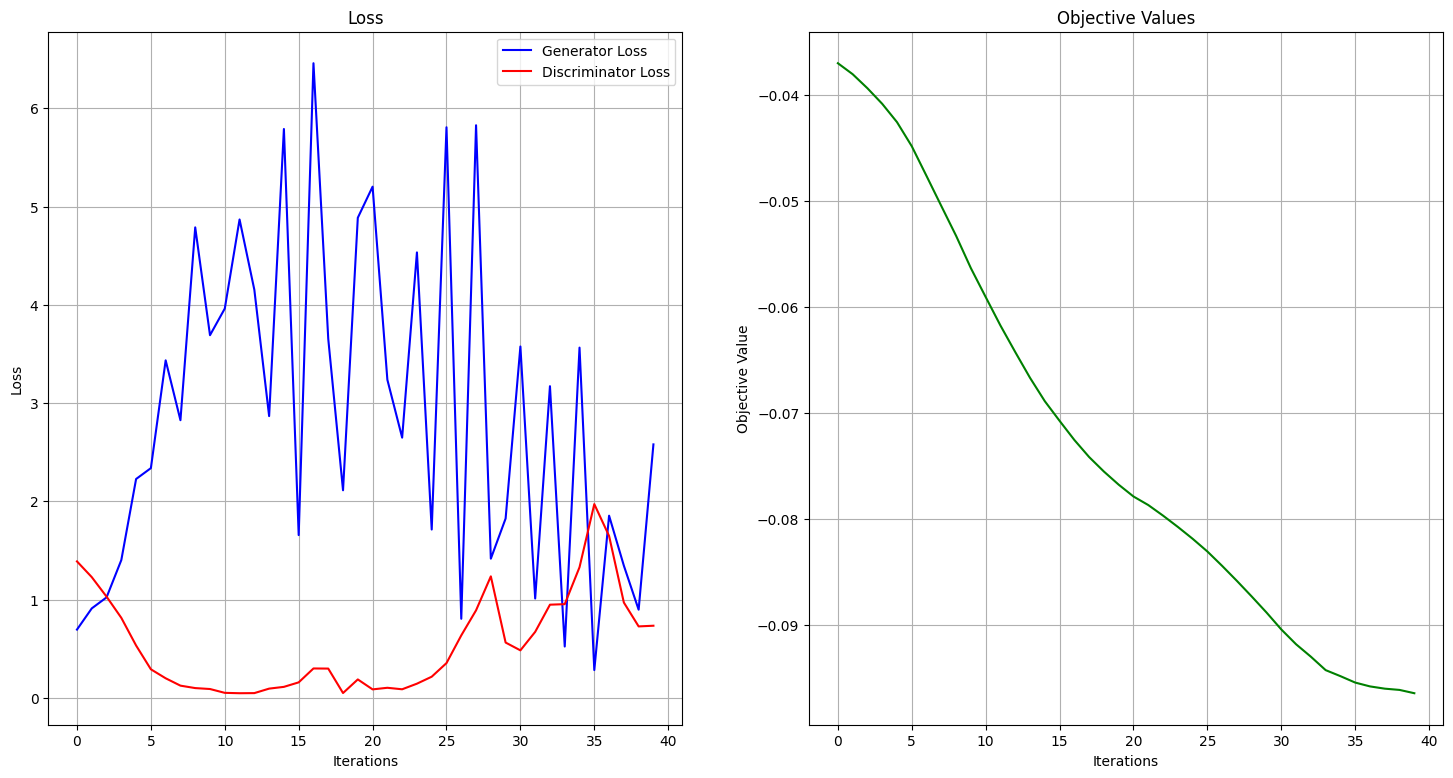

G Loss: 2.5791, D Loss: 0.7336: 100%|██████████| 40/40 [31:25<00:00, 47.14s/it]


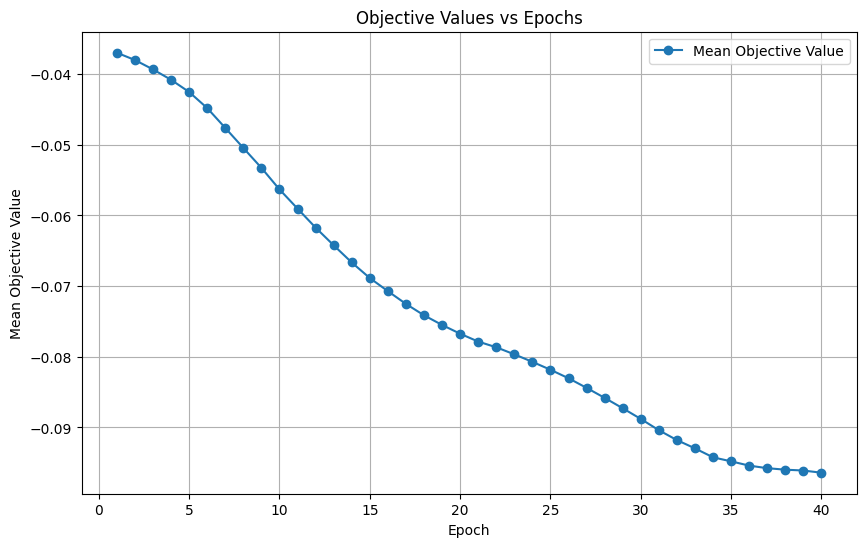

In [15]:
device = "cuda" if torch.cuda.is_available() else 'cpu'

generator_loss_values = []
discriminator_loss_values = []
objective_values_per_epoch = []

class QuantumGAN:
    def __init__(self, num_dim=1, num_discrete_values=16, shots=10000):
        self.num_dim = num_dim
        self.num_discrete_values = num_discrete_values
        self.num_qubits = num_dim * int(np.log2(num_discrete_values))

        # Quantum Circuit Setup
        self.qc = self._create_quantum_circuit()
        self.sampler = Sampler(options={"shots": shots, "seed": algorithm_globals.random_seed})

        # Generator and Discriminator
        self.generator = self._create_generator().to(device)
        self.discriminator = self._create_discriminator().to(device)

        # Optimizers
        self.generator_optimizer = Adam(self.generator.parameters(), lr=0.01, betas=(0.7, 0.999), weight_decay=0.005)
        self.discriminator_optimizer = Adam(self.discriminator.parameters(), lr=0.01, betas=(0.7, 0.999), weight_decay=0.005)

        self.criterion = nn.BCELoss()

    def _create_quantum_circuit(self):
        qc = QuantumCircuit(self.num_qubits)
        qc.h(range(self.num_qubits))
        ansatz = EfficientSU2(self.num_qubits, reps=5)
        qc.compose(ansatz, inplace=True)
        return qc

    def _create_generator(self):
        qnn = SamplerQNN(
            circuit=self.qc,
            sampler=self.sampler,
            input_params=[],
            weight_params=self.qc.parameters,
            sparse=False,
        )
        initial_weights = algorithm_globals.random.random(self.qc.num_parameters)
        return TorchConnector(qnn, initial_weights)

    def _create_discriminator(self):
        return nn.Sequential(
            nn.Linear(5, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def generate_samples(self, batch_size=64):
        samples = []
        for _ in range(batch_size):
            sample = self.generator()[:5].to(device)
            samples.append(sample)
        return torch.stack(samples).float().to(device)

    def objective(self, portfolio_allocations):
        lambda_ = 0.5  # Return-risk trade-off parameter
        total_objective = []

        global mean, covariance
        # Ensure that all values are float64
        mean = mean.float()
        covariance = covariance.float()

        for portfolio in portfolio_allocations:
            portfolio = portfolio.float()  
            risk = torch.sum(torch.matmul(portfolio.unsqueeze(0), covariance) * portfolio)
            returns = torch.sum(mean * portfolio)
            # constraint = torch.sum(portfolio) 
            objective_value = lambda_ * risk - (1 - lambda_) * returns
            total_objective.append(objective_value)

        return torch.tensor(total_objective, dtype=torch.float, device=device)


    def train(self, num_epochs=5, batch_size=64):
        initial_seed = initial_seed = torch.from_numpy(np.array(pd.read_csv("../data/initial_seed.csv", index_col=0))).to(device)

        pbar = tqdm(range(num_epochs))
        objective_values_per_epoch = []

        for epoch in pbar:
            # Discriminator Training
            self.discriminator_optimizer.zero_grad()

            real_samples = initial_seed[torch.randperm(initial_seed.size(0))[:batch_size]]
            real_samples = real_samples.float()

            real_labels = torch.ones(batch_size, 1, device=device)

            fake_samples = self.generate_samples(batch_size)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            d_real_output = self.discriminator(real_samples)
            d_real_loss = self.criterion(d_real_output, real_labels)

            d_fake_output = self.discriminator(fake_samples)
            d_fake_loss = self.criterion(d_fake_output, fake_labels)

            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            self.discriminator_optimizer.step()
            discriminator_loss_values.append(d_loss.item())

            # Generator Training
            self.generator_optimizer.zero_grad()

            generated_samples = self.generate_samples(batch_size)
            g_fake_output = self.discriminator(generated_samples)

            objective_values = self.objective(generated_samples)
            g_loss = self.criterion(g_fake_output, real_labels) + torch.mean(objective_values)

            g_loss.backward()
            self.generator_optimizer.step()
            generator_loss_values.append(g_loss.item())

            # Log the mean objective value for this epoch
            mean_objective_value = torch.mean(objective_values).item()
            objective_values_per_epoch.append(mean_objective_value)

            plot_training_progress(generator_loss_values, discriminator_loss_values, objective_values_per_epoch)

            # Progress tracking
            pbar.set_description(f"G Loss: {g_loss.item():.4f}, D Loss: {d_loss.item():.4f}")

        # Plotting the results
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, num_epochs + 1), objective_values_per_epoch, marker='o', label='Mean Objective Value')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Objective Value')
        plt.title('Objective Values vs Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()

        return initial_seed

gan = QuantumGAN()
final_seed = gan.train(num_epochs=40)
